# Analyze Historical Stock Price data, Propose and Compare Different Investment Strategies

Group: **Thao Nguyen, Brian Murray, Chris Fountain, Rohith Garakurthi**

# Import Libs

In [ ]:
# download solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
# import helpful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

In [ ]:
# install and import stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1270 sha256=757aa67f8003eae62714bdafe8f4e9b5136e4e3efbbef82d0e3f5e340833215a
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=0bbc75bb9a64c08d97aa5f1d59470c59c31982a1753a84709abc0cab7d7f4028
  Stored in directory: /root/.cache/pip/wheels/70/4b/f0/ea

# 1 - Data Preparation and EDA


## 1.1 Data Retrieval and Cleaning

We decided to get data for the following stocks:

1. Communication Services sector:
  - T-Mobile (TMUS)
  - Netflix (NFLX)
  - AT&T (T)
2. Health Care sector:
  - UnitedHealth Group (UNH)
  - Boston Scientific (BSX)
  - Pfizer (PFE)
3. Consumer Staples sector:
  - Walmart (WMT)
  - Procter & Gamble (PG)
  - Costco (COST)

In [ ]:
# assign the ticker list that we want to scrape
tickers_list = ['TMUS','NFLX','T','UNH','BSX','PFE','WMT','PG','COST']
# pull historical price data for each stocks
dow_prices = {ticker : si.get_data(ticker,start_date = '1/1/2017',end_date='1/1/2022',interval='1d') for ticker in tickers_list}
# end_date is 1/1/2022 because we need data of 12/31/2021

In [ ]:
# extract just the data we need (adjclose)
# get the adjclose price for the first stock in list
prep_data = pd.DataFrame(dow_prices[tickers_list[0]]['adjclose']).rename(columns = {"adjclose":tickers_list[0]})
# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])

In [ ]:
# Just to check that everything imported correctly
print(prep_data.head(5))
print(prep_data.tail(5))

                 TMUS        NFLX          T         UNH        BSX  \
2017-01-03  58.320000  127.489998  19.597078  147.298828  21.879999   
2017-01-04  58.820000  129.410004  19.483191  147.718521  22.080000   
2017-01-05  57.610001  131.809998  19.428530  147.964844  22.049999   
2017-01-06  56.770000  131.070007  19.113413  148.174667  22.150000   
2017-01-09  56.669998  130.949997  18.872875  147.754974  22.190001   

                  PFE        WMT         PG        COST  
2017-01-03  24.884718  60.832012  70.369576  141.398987  
2017-01-04  25.103403  61.186405  70.620293  141.425552  
2017-01-05  25.344709  61.319313  71.088310  144.214005  
2017-01-06  25.246683  60.477600  71.063232  144.143188  
2017-01-09  25.239141  60.876312  70.536720  142.496674  
                  TMUS        NFLX          T         UNH        BSX  \
2021-12-27  118.580002  613.119995  16.929985  491.433594  43.119999   
2021-12-28  118.160004  610.710022  16.957314  494.818024  43.240002   
2021-12-2

In [ ]:
# check number of NAs for each column
prep_data.isna().sum()

TMUS    0
NFLX    0
T       0
UNH     0
BSX     0
PFE     0
WMT     0
PG      0
COST    0
dtype: int64

In [ ]:
# drop the NA records just to be sure
prep_data.dropna(inplace=True)

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# drop the na records
return_data.dropna(inplace=True)

In [ ]:
# calculate the cumulative daily returns
cum_daily_returns = ((1 + return_data).cumprod() - 1)*100

This is just a visual check to make sure the above code did what it was supposed to do.

In [ ]:
# summarize the dataframe
summary = cum_daily_returns.describe()
print(summary)

              TMUS         NFLX            T          UNH          BSX  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean     49.433067   185.640606    -7.236981    79.721747    62.742476   
std      47.672777   110.136422     8.162043    54.032422    28.941296   
min      -5.075444     1.325590   -26.765483    -2.372258     0.776966   
25%       9.550754   113.210845   -13.006300    43.352546    32.518286   
50%      30.452672   177.253123    -7.852742    65.402409    69.012801   
75%      95.949075   285.710645    -3.554271   108.229639    88.014175   
max     156.189994   442.544524    15.329875   237.691311   109.689227   

               PFE          WMT           PG         COST  
count  1258.000000  1258.000000  1258.000000  1258.000000  
mean     30.375367    71.008846    42.486409    88.126196  
std      22.694063    42.635415    35.228105    70.554469  
min      -5.606051    -4.369349   -11.640150    -1.460311  
25%      14.731795    33.356690  

## 1.2 Time Series Visualizations

### 1.2.1 Visualization of Sector Communication Services

In [ ]:
plt.rcParams['figure.figsize'] = 12, 6

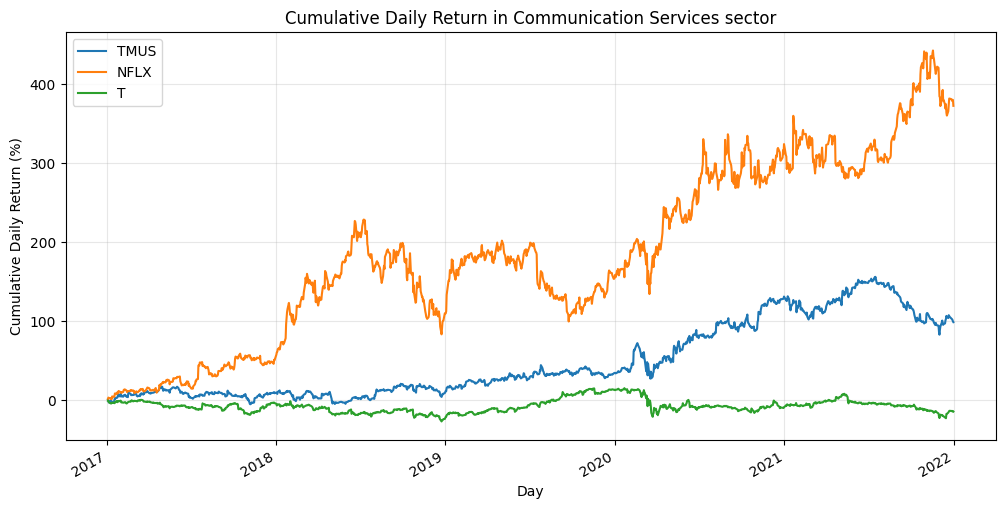

In [ ]:
# Communication Services
# plot
cum_daily_returns1 = cum_daily_returns[tickers_list[0:3]]
cum_daily_returns1.plot()
# title and labels
plt.xlabel('Day')
plt.ylabel('Cumulative Daily Return (%)')
plt.title('Cumulative Daily Return in Communication Services sector')
# set legend location
plt.legend(loc="upper left")
plt.grid(True, alpha = .3)
plt.show()

### 1.2.2 Visualization of Sector Health Care

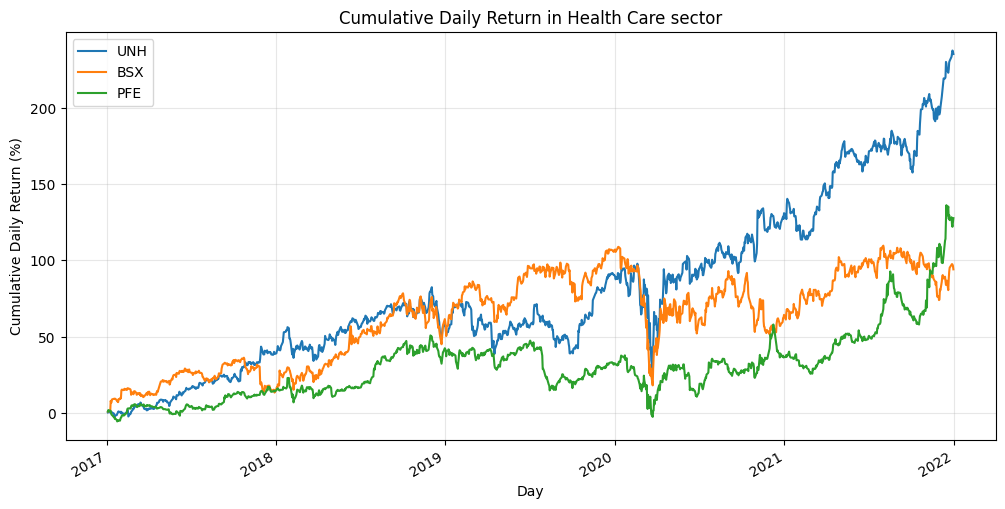

In [ ]:
# Health Care
# plot
cumsum_return_data2 = cum_daily_returns[tickers_list[3:6]]
cumsum_return_data2.plot()
# title and labels
plt.xlabel('Day')
plt.ylabel('Cumulative Daily Return (%)')
plt.title('Cumulative Daily Return in Health Care sector')
# set legend location
plt.legend(loc="upper left")
plt.grid(True, alpha = .3)
plt.show()

### 1.2.3 Visualization of Sector Consumer Staples

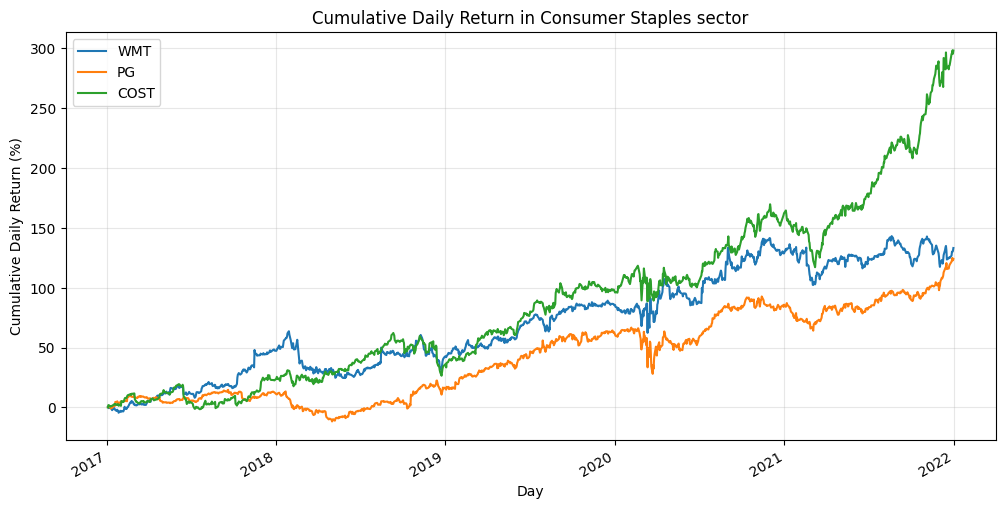

In [ ]:
# Consumer Staples
# plot
cumsum_return_data3 = cum_daily_returns[tickers_list[6:9]]
cumsum_return_data3.plot()
# title and labels
plt.xlabel('Day')
plt.ylabel('Cumulative Daily Return (%)')
plt.title('Cumulative Daily Return in Consumer Staples sector')
# set legend location
plt.legend(loc="upper left")
plt.grid(True, alpha = .3)
plt.show()

## 1.3 Discussion of the Plots

### 1.3.1 Communication Services

Netflix increased very fast. The return was very high, it peaked at above 400%. At the end of the period, the return was between 300% and 400%. However, it flunctuated very much. The votality indicates high risks.

T-Mobile is in the middle. It increased fast but not fast enough compared to Netflix of the same sector. The return was still high, it peaked at about 150%, and at the end of the period, it was above 100%. The votality indicates middle-ranged risks.

AT&T is the most stable of the three in the communication services sector, but the return is very low and even negative most of the time. The trend is decreasing return over time.

### 1.3.2 Health Care

The health care sector is much more complicated than other two sectors.

UnitedHealth has the highest return at the end of the period at above 200%. The overall trend is increasing over the time. It experienced a very low dip at the beginning of 2020. The votality indicates high risks.

Boston Scientific has the lowest return at the end of the period among the three in this sector at about 100%. However, there were times in 2017 and 2019 when it has the highest return. It also experienced a very low dip at the beginning of 2020. The increasing trend is not very clear. The votality indicates high risks.

Pfizer has the lowest return rate for most of the period but increased very fast at the end of 2021 and became the second highest in return at about 125%. It also experienced a dip at the beginning of 2020 but not as severe as the other two of the same sector. The votality indicates middle-ranged risks.

### 1.3.3 Consumer Staples

The consumer staples sector is more stable than the other two sectors.

Walmart was in the middle most of the period. However, there was a time from mid 2017 to first few months of 2018 when it rose to the top. At the end of the period, its return was slightly above 125%. The votality indicates middle-range risks.

Procter & Gamble has the lowest return of this sector. It ended the period with slightly below 125%. However, it did not flunctuate very much. The votality indicates low risks.

Costco has the highest return of the sector. It had consistent increasing trend over time and ended with return at about 300%. It increased especially fast in the last 3 quarters of 2021. The votality indicates middle-range risks.

# 2 - Optimization Model

## 2.1 Model execution

### 2.1.1 Calculate Covariance and Average Return

In [ ]:
# creating covariance table on stock return dataframe
df_cov = return_data.cov()
# create the average of each stock
# these are the objective function COEFFICIENTS!
df_return = return_data.mean()

### 2.1.2 Concrete Model

In [ ]:
from pyomo.environ import *
m = ConcreteModel()

### 2.1.3 Define variables

In [ ]:
# defining variables
# each one is a stock
m.x1 = Var(within=NonNegativeReals, bounds=(0,1)) #TMUS
m.x2 = Var(within=NonNegativeReals, bounds=(0,1)) #NFLX
m.x3 = Var(within=NonNegativeReals, bounds=(0,1)) #T
m.x4 = Var(within=NonNegativeReals, bounds=(0,1)) #UNH
m.x5 = Var(within=NonNegativeReals, bounds=(0,1)) #BSX
m.x6 = Var(within=NonNegativeReals, bounds=(0,1)) #PFE
m.x7 = Var(within=NonNegativeReals, bounds=(0,1)) #WMT
m.x8 = Var(within=NonNegativeReals, bounds=(0,1)) #PG
m.x9 = Var(within=NonNegativeReals, bounds=(0,1)) #COST

# binary varibles
m.y1 = Var(within=Binary) #TMUS
m.y2 = Var(within=Binary) #NFLX
m.y3 = Var(within=Binary) #T
m.y4 = Var(within=Binary) #UNH
m.y5 = Var(within=Binary) #BSX
m.y6 = Var(within=Binary) #PFE
m.y7 = Var(within=Binary) #WMT
m.y8 = Var(within=Binary) #PG
m.y9 = Var(within=Binary) #COST

### 2.1.4 Declare Objective

In [ ]:
# declare objective
m.objective = Objective(expr = m.x1*m.y1*df_return[0] + #TMUS
                               m.x2*m.y2*df_return[1] + #NFLX
                               m.x3*m.y3*df_return[2] + #T
                               m.x4*m.y4*df_return[3] + #UNH
                               m.x5*m.y5*df_return[4] + #BSX
                               m.x6*m.y6*df_return[5] + #PFE
                               m.x7*m.y7*df_return[6] + #WMT
                               m.x8*m.y8*df_return[7] + #PG
                               m.x9*m.y9*df_return[8],  #COST
                        sense = maximize)

### 2.1.5 Constraints

#### 2.1.5.1 Sum of all proportions

In [ ]:
# Sum of all proportions = 1
m.sum_proportions = Constraint(expr = m.x1 +
                                      m.x2 +
                                      m.x3 +
                                      m.x4 +
                                      m.x5 +
                                      m.x6 +
                                      m.x7 +
                                      m.x8 +
                                      m.x9 == 1)

#### 2.1.5.2 Maximum Risk

In [ ]:
# Set maximum risk constraint
# INCLUDING THIS CONSTRAINT NOW FOR TECHNICAL REASONS
m.total_risk = Constraint(expr = m.x1 +
                                 m.x2 +
                                 m.x3 +
                                 m.x4 +
                                 m.x5 +
                                 m.x6 +
                                 m.x7 +
                                 m.x8 +
                                 m.x9 >= 0.0)

In [ ]:
# creating calculations table for calculate the risk
# Calculate risk
def calc_risk(m):
  variables = m.x1, m.x2, m.x3, m.x4, m.x5, m.x6, m.x7, m.x8, m.x9
  tickers = tickers_list
  risk_exp = 0
  for i in range(len(variables)):
    for j in range(len(variables)):
      risk_exp += variables[i]*df_cov.at[tickers[i],tickers[j]]*variables[j]
  return risk_exp

# We are going to use this expression to compute the risk
expr_risk = calc_risk(m)

In [ ]:
# Max risk
max_risk = 0.0007

# Step size
step_size = max_risk/100 # take tiny steps

# Sequence of risk levels
risk_limits = np.arange(0, max_risk+step_size, step_size) # max_risk+step_size to ensure that max_risk is in the array

#### 2.1.5.3 Linking constraints

In [ ]:
# LINKING CONSTRAINTS
# which can help us decide if we should even invest in that stock!
m.l1 = Constraint(expr = m.x1 - 1*m.y1 <= 0) #TMUS
m.l2 = Constraint(expr = m.x2 - 1*m.y2 <= 0) #NFLX
m.l3 = Constraint(expr = m.x3 - 1*m.y3 <= 0) #T
m.l4 = Constraint(expr = m.x4 - 1*m.y4 <= 0) #UNH
m.l5 = Constraint(expr = m.x5 - 1*m.y5 <= 0) #BSX
m.l6 = Constraint(expr = m.x6 - 1*m.y6 <= 0) #PFE
m.l7 = Constraint(expr = m.x7 - 1*m.y7 <= 0) #WMT
m.l8 = Constraint(expr = m.x8 - 1*m.y8 <= 0) #PG
m.l9 = Constraint(expr = m.x9 - 1*m.y9 <= 0) #COST

### 2.1.6 Run the model

In [ ]:
# updating risk contraint for each limit and then solving the problem
param_analysis = {} # key=risk, value =stock allocations
returns = {} # key=risk, value = return
for r in risk_limits:
  # WE REMOVE AND RECALCULATE THE RISK IN EACH ITERATION
  m.del_component(m.total_risk)
  # The LHS remains unchanged; we only modify the RHS (risk threshold)
  m.total_risk = Constraint(expr = expr_risk <= r)
  # run solver
  try:
    result = SolverFactory('bonmin', executable='/content/bin/bonmin').solve(m).write()
    # store our allocation proportions
    param_analysis[r] = [m.x1(), m.x2(), m.x3(), m.x4(), m.x5(), m.x6(), m.x7(), m.x8(), m.x9()]
    # store our returns
    returns[r] = m.objective()
  except:
    print('Infeasible!')
    continue # move to the next risk level

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.18596363067626953
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.19389033317565918
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.14303159713745117
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 9.390093326568604
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasible

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.27659082412719727
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 8.331660747528076
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasible

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.13167405128479004
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.10525989532470703
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.14644813537597656
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.21485209465026855
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.16413187980651855
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.0840456485748291
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasibl

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.04527783393859863
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.08693361282348633
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasib

  - termination condition: infeasible
  - message from solver: bonmin\x3a Infeasible problem
ERROR:pyomo.core:evaluating object as numeric value: x1
    (object: <class 'pyomo.core.base.var.ScalarVar'>)
No value for uninitialized NumericValue object x1


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 0
  Number of variables: 0
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: warning
  Message: bonmin\x3a Infeasible problem
  Termination condition: infeasible
  Id: 220
  Error rc: 0
  Time: 0.046957969665527344
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
Infeasi

Note that multiple solutions were discarded for being "infeasible".

## 2.2 Plot with allocation of the stocks

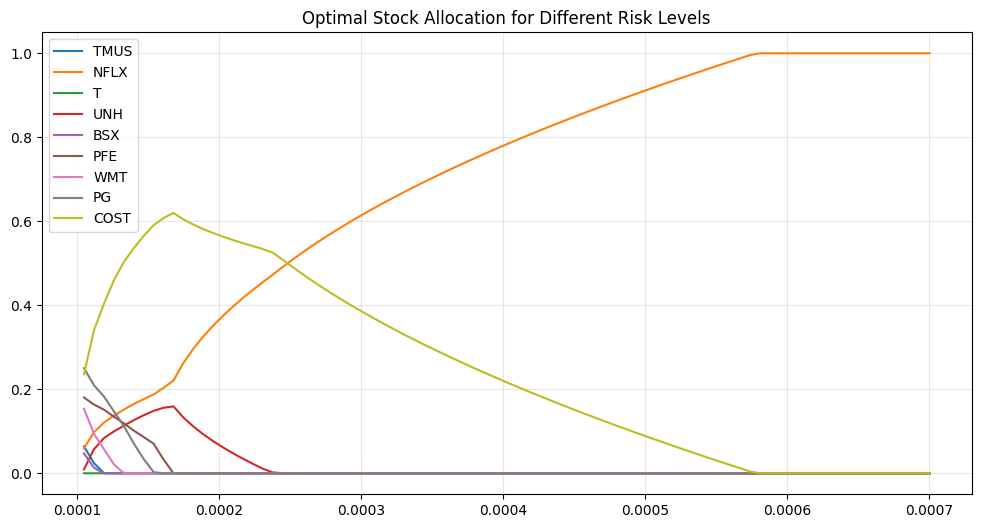

In [ ]:
# generating the dataframe for proportions of the portfolio for each risk limit
param_analysis = pd.DataFrame.from_dict(param_analysis, orient='index')
param_analysis.dropna(inplace = True)
param_analysis.columns = tickers_list
param_analysis.plot()
plt.title('Optimal Stock Allocation for Different Risk Levels')
plt.grid(True, alpha = .3)
plt.show()

As you can see, the porfolio variation ceases by the time we get to our arbitrary max_risk value.

## 2.3 Plot with efficient frontier

In [ ]:
risk = list(returns.keys()) # coerce dict_keys to a list
reward = list(returns.values()) # coerce dict_values to a list

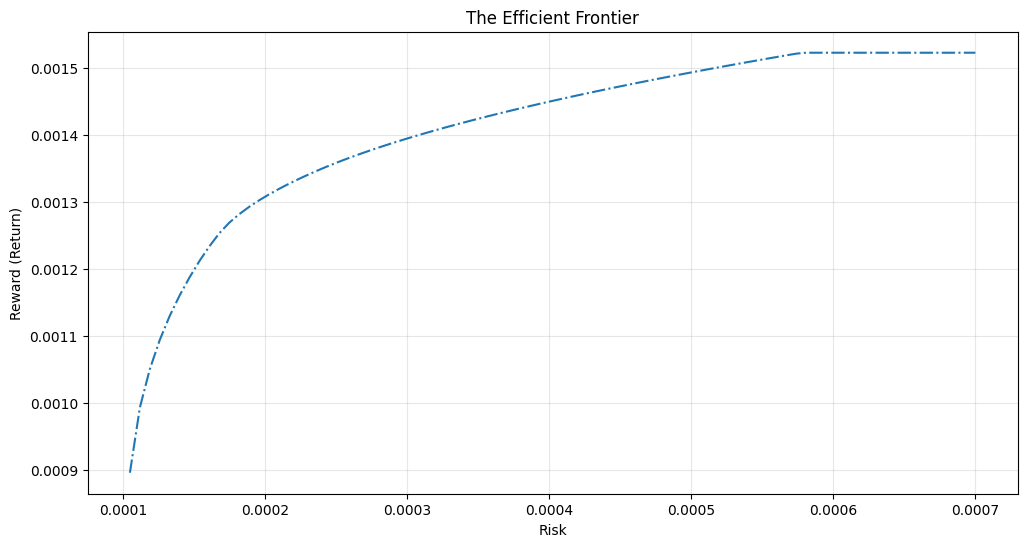

In [ ]:
plot(risk, reward, '-.')
title('The Efficient Frontier')
xlabel('Risk')
ylabel('Reward (Return)')
plt.grid(True, alpha = .3)
plt.show()

## 2.4 Portfolio selection

We decided to look more closely in to the range of risk level between 0.00015 and 0.00025 because solutions in that range ensure a diverse enough portfolio.

In [ ]:
# show the allocation of stocks for each risk level (rounded to 4 decimal places)
round(param_analysis[0.00015:0.00025], 4)

,TMUS,NFLX,T,UNH,BSX,PFE,WMT,PG,COST
0.000154,0.0,0.1877,0.0,0.1486,0.0,0.0704,0.0,0.0027,0.5907
0.000161,0.0,0.2034,0.0,0.1560,0.0,0.0327,0.0,0.0001,0.6078
0.000168,0.0,0.2210,0.0,0.1592,0.0,0.0000,0.0,0.0000,0.6198
0.000175,0.0,0.2629,0.0,0.1326,0.0,0.0000,0.0,0.0000,0.6044
0.000182,0.0,0.2968,0.0,0.1112,0.0,0.0000,0.0,0.0000,0.5921
0.000189,0.0,0.3259,0.0,0.0927,0.0,0.0000,0.0,0.0000,0.5814
0.000196,0.0,0.3519,0.0,0.0763,0.0,0.0000,0.0,0.0000,0.5719
0.000203,0.0,0.3755,0.0,0.0613,0.0,0.0000,0.0,0.0000,0.5632
0.000210,0.0,0.3974,0.0,0.0474,0.0,0.0000,0.0,0.0000,0.5552
0.000217,0.0,0.4178,0.0,0.0344,0.0,0.0000,0.0,0.0000,0.5477


We decided to select the portfolio at the risk level of 0.000196 where:
- 35.19% is in NFLX for Communication Services sector
- 7.63% is in UNH for Health Care sector
- 57.18% is in COST for Comsumer Staples sector

In [ ]:
# set the part for each stock
nflx_part = 0.3519
unh_part = 0.0763
cost_part = 0.5718

In [ ]:
# the given invest fund
invest_fund = 100000

In [ ]:
# calculate the investment in each stock
nflx_invest = nflx_part*invest_fund
print("Invest in NFLX: $" + str(round(nflx_invest, 2)))
unh_invest = unh_part*invest_fund
print("Invest in UNH: $" + str(round(unh_invest, 2)))
cost_invest = cost_part*invest_fund
print("Invest in COST: $" + str(round(cost_invest, 2)))

Invest in NFLX: $35190.0
Invest in UNH: $7630.0
Invest in COST: $57180.0


# 3 - Analysis

First, we need to get stock data for 2022.

In [ ]:
# assign the ticker list that we want to scrape
tickers_select = ['NFLX', 'UNH', 'COST']
df = {ticker : si.get_data(ticker,start_date = '12/2/2021',end_date='1/1/2023',interval='1d') for ticker in tickers_select}
# start_date is 12/2/2021 because we need data for moving average of previous 21 days for 1/1/2022
# end_date is 1/1/2023 because we need data of 12/31/2022

In [ ]:
# first trading day of each month
# some months have the 2nd or 3rd day of the month instead of the 1st for the first trading day
first_day_of_month = ['2022-01-03','2022-02-01','2022-03-01','2022-04-01','2022-05-02','2022-06-01',
                      '2022-07-01','2022-08-01','2022-09-01','2022-10-03','2022-11-01','2022-12-01']

## 3.1 Buy-and-Hold strategy for the MPT portfolio

In [ ]:
# create a dataframe to store data for buy-and-hold strategy
buy_hold1 = pd.DataFrame()

In [ ]:
# store prices data into dataframe
buy_hold1['NFLX_prices'] = df['NFLX']['close']
buy_hold1['UNH_prices'] = df['UNH']['close']
buy_hold1['COST_prices'] = df['COST']['close']

In [ ]:
# trim the dataframe from 1/1/2022 only, we do not need 2021 data here
buy_hold1 = buy_hold1.loc['2022-1-1'::]

In [ ]:
# this is the price of the stock when we first buy it on the first trading day of 2022 (Jan 3 because Jan 1 and Jan 2 are not trading day)
nflx_buy_price = buy_hold1.loc['2022-01-03', 'NFLX_prices']
unh_buy_price = buy_hold1.loc['2022-01-03', 'UNH_prices']
cost_buy_price = buy_hold1.loc['2022-01-03', 'COST_prices']

In [ ]:
# this is the shares of the stock we were able to buy on the first trading day of 2022 (Jan 3 because Jan 1 and Jan 2 are not trading day)
nflx_shares = nflx_invest/nflx_buy_price
unh_shares = unh_invest/unh_buy_price
cost_shares = cost_invest/cost_buy_price

In [ ]:
# the amount of money invested in each stock on the first day of each month
buy_hold1['NFLX_invest'] = buy_hold1['NFLX_prices']*nflx_shares
buy_hold1['UNH_invest'] = buy_hold1['UNH_prices']*unh_shares
buy_hold1['COST_invest'] = buy_hold1['COST_prices']*cost_shares

In [ ]:
# aggregate value of the entire portfolio
buy_hold1['value'] = buy_hold1['NFLX_invest'] + buy_hold1['UNH_invest'] + buy_hold1['COST_invest']

In [ ]:
# calculate our return
buy_hold1['return'] = buy_hold1['value'] - invest_fund

In [ ]:
# show the table without unnecessary columns
buy_hold_1 = buy_hold1.loc[first_day_of_month].copy().reset_index()
buy_hold_1 = buy_hold_1.drop(['NFLX_prices', 'UNH_prices', 'COST_prices'], axis = 1)
buy_hold_1.rename(columns={"index": "day"}, inplace = True)
buy_hold_1

,day,NFLX_invest,UNH_invest,COST_invest,value,return
0,2022-01-03,35190.000000,7630.000000,57180.000000,100000.000000,0.000000
1,2022-02-01,26928.712529,7115.490039,51297.635267,85341.837835,-14658.162165
2,2022-03-01,22752.708317,7234.585309,52762.675481,82749.969107,-17250.030893
3,2022-04-01,22000.451061,7786.616856,58073.956244,87861.024161,-12138.975839
4,2022-05-02,11749.832924,7612.834401,53370.084391,72732.751715,-27267.248285
5,2022-06-01,11363.983937,7482.194027,46109.450386,64955.628350,-35044.371650
6,2022-07-01,10600.533077,7859.684232,49012.292498,67472.509807,-32527.490193
7,2022-08-01,13325.627670,8132.813266,55172.124099,76630.565035,-23369.434965
8,2022-09-01,13551.245342,7959.942681,53392.279031,74903.467054,-25096.532946
9,2022-10-03,14081.419275,7830.973529,48202.080375,70114.473179,-29885.526821


At the end of the year, we lose $22,334.44 with this strategy 😞

## 3.2 Momentum trading strategy for each stock in the MPT portfolio

##### NFLX

In [ ]:
nflx = df['NFLX'].copy() # create dataframe for nflx
nflx.drop(['open', 'high', 'low', 'adjclose', 'volume', 'ticker'], axis=1, inplace=True) # drop columns we do not need
nflx['logClose'] = np.log(nflx['close']) # price will always be positive, so this operation is well-defined
nflx['return'] = nflx['logClose'].diff() # the difference will be positive or negative

###### Add "invested" column  

In [ ]:
nflx['8-day'] = nflx['close'].rolling(8).mean().shift() # calculate 8-day average
nflx['21-day'] = nflx['close'].rolling(21).mean().shift() # calculate 21-day average
nflx.dropna(inplace=True) # remove NAs
# we did use the data from 2021 so that after dropping NAs, we still have data starting from the first trading day of 2022

In [ ]:
# make a column to determine whether we should invest or not on that day
# 1 = YES
# 0 = NO
nflx['invested'] = np.where(nflx['8-day'] > nflx['21-day'], 1, 0)

In [ ]:
# see how many days we invest money in and how many days we take money out
print(nflx['invested'].value_counts())

0    133
1    118
Name: invested, dtype: int64


###### Entering and leaving the market


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
# 1 = BUY
# 0 = Do nothing
# -1 = SELL
nflx['signal'] = nflx['invested'].diff()
nflx.loc["2022-01-03",'signal'] = 1 # set signal to buy nflx_invest on the first trading day

In [ ]:
# see how many days we buy, how many days we sell, and how many days we do nothing
print(nflx['signal'].value_counts())

 0.0    237
 1.0      7
-1.0      7
Name: signal, dtype: int64


###### Plot trades on time series for 2022

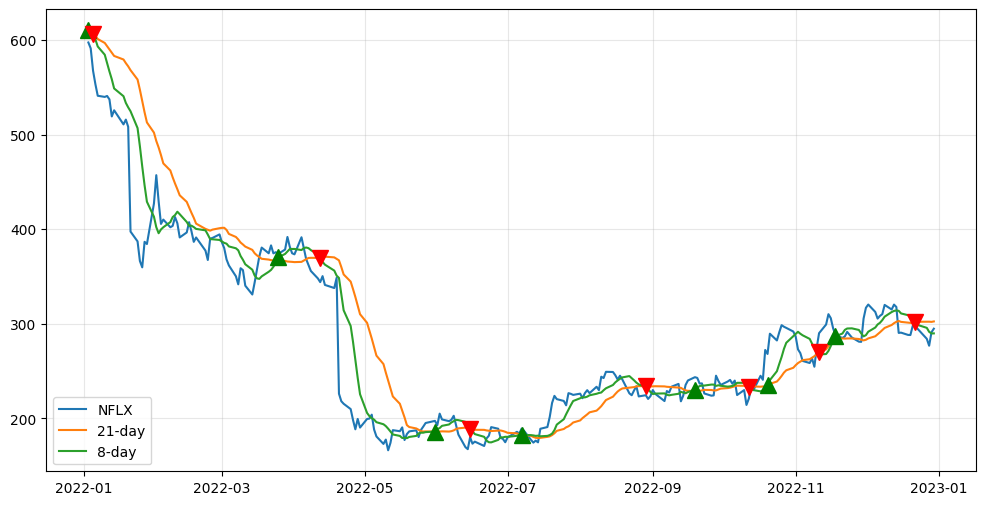

In [ ]:
# show the last year
plt.plot(nflx['close'], label = 'NFLX') # actual value
plt.plot(nflx['21-day'], label = '21-day') # 21-day average
plt.plot(nflx['8-day'], label = '8-day') # 8-day average
plt.plot(nflx.loc[nflx.signal == 1].index, nflx['8-day'][nflx.signal == 1], '^',
         color = 'g', markersize = 12) # buy
plt.plot(nflx.loc[nflx.signal == -1].index, nflx['21-day'][nflx.signal == -1], 'v',
         color = 'r', markersize = 12) # sell
plt.grid(True, alpha = .3) # grid
plt.legend(loc='lower left') # legend
plt.show()

###### System return

In [ ]:
# The 'system_return' tells you how much money we would have made using momentum trading
nflx['system_return'] = nflx['invested'] * nflx['return']

In [ ]:
# calculate cumulative system return
nflx['cum_system_return'] = nflx['system_return'].cumsum()

In [ ]:
# translate the system return into money return
nflx['money_return'] = (np.exp(nflx['cum_system_return'])-1)*nflx_invest
# setting the return of first day to 0
nflx.loc["2022-01-03",'money_return'] = 0

In [ ]:
# calculate how much money we have in NFLX
nflx['NFLX_invest'] = nflx_invest + nflx['money_return']

In [ ]:
# show the table for first day of every month without unnecessary columns
nflx1 = nflx.loc[first_day_of_month].copy().reset_index()
nflx1.drop(['close', 'logClose', 'return', '8-day', '21-day', 'invested', 'signal', 'system_return', 'cum_system_return'], axis = 1, inplace = True)
nflx1.rename(columns={"index": "day", "money_return": "NFLX_return"}, inplace = True)
nflx1 = nflx1[['day', 'NFLX_invest', 'NFLX_return']]
nflx1

,day,NFLX_invest,NFLX_return
0,2022-01-03,35190.000000,0.000000
1,2022-02-01,34530.524658,-659.475342
2,2022-03-01,34530.524658,-659.475342
3,2022-04-01,34324.653002,-865.346998
4,2022-05-02,31983.771670,-3206.228330
5,2022-06-01,31610.171796,-3579.828204
6,2022-07-01,27453.049971,-7736.950029
7,2022-08-01,33739.838643,-1450.161357
8,2022-09-01,33302.819979,-1887.180021
9,2022-10-03,33151.649949,-2038.350051


At the end of the year, we lose $2,986.48 on NFLX with this strategy 😞

##### UNH

In [ ]:
unh = df['UNH'].copy() # create dataframe for unh
unh.drop(['open', 'high', 'low', 'adjclose', 'volume', 'ticker'], axis=1, inplace=True) # drop columns we do not need
unh['logClose'] = np.log(unh['close']) # price will always be positive, so this operation is well-defined
unh['return'] = unh['logClose'].diff() # the difference will be positive or negative

###### Add "invested" column

In [ ]:
unh['8-day'] = unh['close'].rolling(8).mean().shift() # calculate 8-day average
unh['21-day'] = unh['close'].rolling(21).mean().shift() # calculate 21-day average
unh.dropna(inplace=True) # remove NAs
# we did use the data from 2021 so that after dropping NAs, we still have data starting from the first trading day of 2022

In [ ]:
# make a column to determine whether we should invest or not on that day
# 1 = YES
# 0 = NO
unh['invested'] = np.where(unh['8-day'] > unh['21-day'], 1, 0)

In [ ]:
# see how many days we invest money in and how many days we take money out
print(unh['invested'].value_counts())

1    138
0    113
Name: invested, dtype: int64


###### Entering and leaving the market


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
# 1 = BUY
# 0 = Do nothing
# -1 = SELL
unh['signal'] = unh['invested'].diff()
unh.loc["2022-01-03",'signal'] = 1 # set signal to unh_invest, buy on the first trading day

In [ ]:
# see how many days we buy, how many days we sell, and how many days we do nothing
print(unh['signal'].value_counts())

 0.0    237
 1.0      7
-1.0      7
Name: signal, dtype: int64


###### Plot trades on time series for 2022

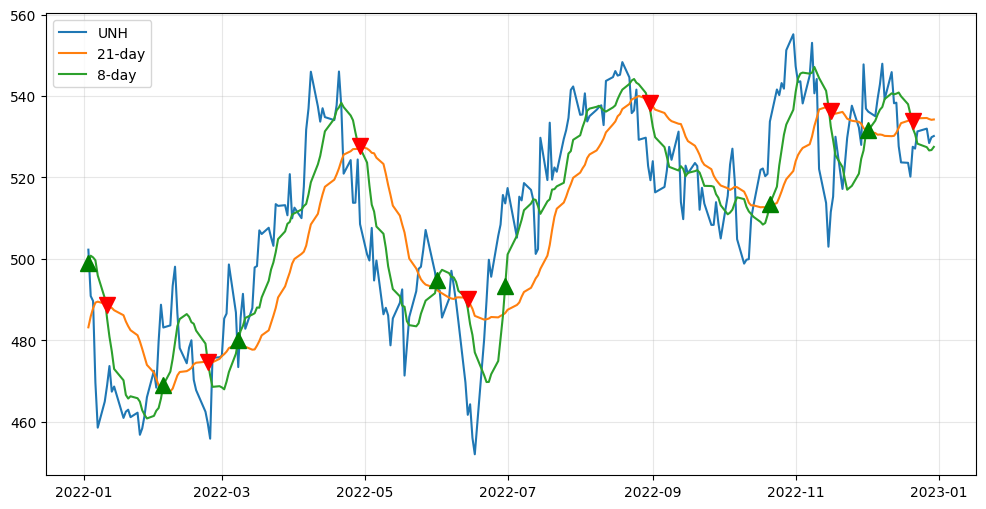

In [ ]:
# show the last year
plt.plot(unh['close'], label = 'UNH') # actual value
plt.plot(unh['21-day'], label = '21-day') # 21-day average
plt.plot(unh['8-day'], label = '8-day') # 8-day average
plt.plot(unh.loc[unh.signal == 1].index, unh['8-day'][unh.signal == 1], '^',
         color = 'g', markersize = 12) # buy
plt.plot(unh.loc[unh.signal == -1].index, unh['21-day'][unh.signal == -1], 'v',
         color = 'r', markersize = 12) # sell
plt.grid(True, alpha = .3) # grid
plt.legend(loc=2) # legend
plt.show()

###### System return

In [ ]:
# The 'system_return' tells you how much money we would have made using momentum trading
unh['system_return'] = unh['invested'] * unh['return']

In [ ]:
# calculate cumulative system return
unh['cum_system_return'] = unh['system_return'].cumsum()

In [ ]:
# translate the system return into money return
unh['money_return'] = (np.exp(unh['cum_system_return'])-1)*unh_invest
# setting the return of first day to 0
unh.loc["2022-01-03",'money_return'] = 0

In [ ]:
# calculate how much money we have in UNH
unh['UNH_invest'] = unh_invest + unh['money_return']

In [ ]:
# show the table for first day of every month without unnecessary columns
unh1 = unh.loc[first_day_of_month].copy().reset_index()
unh1.drop(['close', 'logClose', 'return', '8-day', '21-day', 'invested', 'signal', 'system_return', 'cum_system_return'], axis = 1, inplace = True)
unh1.rename(columns={"index": "day", "money_return": "UNH_return"}, inplace = True)
unh1 = unh1[['day', 'UNH_invest', 'UNH_return']]
unh1

,day,UNH_invest,UNH_return
0,2022-01-03,7630.000000,0.000000
1,2022-02-01,7065.658773,-564.341227
2,2022-03-01,6686.044524,-943.955476
3,2022-04-01,7039.250264,-590.749736
4,2022-05-02,7201.707622,-428.292378
5,2022-06-01,7140.386107,-489.613893
6,2022-07-01,6831.448972,-798.551028
7,2022-08-01,7068.846176,-561.153824
8,2022-09-01,6903.275600,-726.724400
9,2022-10-03,6903.275600,-726.724400


At the end of the year, we lose $963.56 on UNH with this strategy 😞

##### COST

In [ ]:
cost = df['COST'].copy() # create dataframe for cost
cost.drop(['open', 'high', 'low', 'adjclose', 'volume', 'ticker'], axis=1, inplace=True) # drop columns we do not need
cost['logClose'] = np.log(cost['close']) # price will always be positive, so this operation is well-defined
cost['return'] = cost['logClose'].diff() # the difference will be positive or negative

###### Add "invested" column

In [ ]:
cost['8-day'] = cost['close'].rolling(8).mean().shift() # calculate 8-day average
cost['21-day'] = cost['close'].rolling(21).mean().shift() # calculate 21-day average
cost.dropna(inplace=True) # remove NAs
# we did use the data from 2021 so that after dropping NAs, we still have data starting from the first trading day of 2022

In [ ]:
# make a column to determine whether we should invest or not on that day
# 1 = YES
# 0 = NO
cost['invested'] = np.where(cost['8-day'] > cost['21-day'], 1, 0)

In [ ]:
# see how many days we invest money in and how many days we take money out
print(cost['invested'].value_counts())

1    135
0    116
Name: invested, dtype: int64


###### Entering and leaving the market


In [ ]:
# the variable signal tells you when you buy and sell
# we will use it to make red and green triangles
# 1 = BUY
# 0 = Do nothing
# -1 = SELL
cost['signal'] = cost['invested'].diff()
cost.loc["2022-01-03",'signal'] = 1 # set signal to cost_invest, buy on the first trading day

In [ ]:
# see how many days we buy, how many days we sell, and how many days we do nothing
print(cost['signal'].value_counts())

 0.0    239
 1.0      6
-1.0      6
Name: signal, dtype: int64


###### Plot trades on time series for 2022

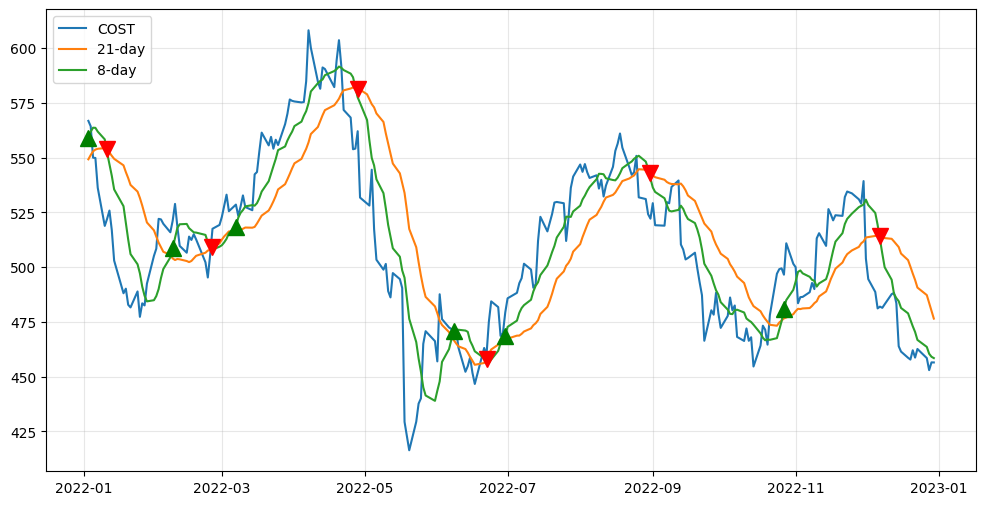

In [ ]:
# show the last year
plt.plot(cost['close'], label = 'COST') # actual value
plt.plot(cost['21-day'], label = '21-day') # 21-day average
plt.plot(cost['8-day'], label = '8-day') # 8-day average
plt.plot(cost.loc[cost.signal == 1].index, cost['8-day'][cost.signal == 1], '^',
         color = 'g', markersize = 12) # buy
plt.plot(cost.loc[cost.signal == -1].index, cost['21-day'][cost.signal == -1], 'v',
         color = 'r', markersize = 12) # sell
plt.grid(True, alpha = .3) # grid
plt.legend(loc=2) # legend
plt.show()

###### System return

In [ ]:
# The 'system_return' tells you how much money we would have made using momentum trading
cost['system_return'] = cost['invested'] * cost['return']

In [ ]:
# calculate cumulative system return
cost['cum_system_return'] = cost['system_return'].cumsum()

In [ ]:
# translate the system return into money return
cost['money_return'] = (np.exp(cost['cum_system_return'])-1)*cost_invest
# setting the return of first day to 0
cost.loc["2022-01-03",'money_return'] = 0

In [ ]:
# calculate how much money we have in COST
cost['COST_invest'] = cost_invest + cost['money_return']

In [ ]:
# show the table for first day of every month without unnecessary columns
cost1 = cost.loc[first_day_of_month].copy().reset_index()
cost1.drop(['close', 'logClose', 'return', '8-day', '21-day', 'invested', 'signal', 'system_return', 'cum_system_return'], axis = 1, inplace = True)
cost1.rename(columns={"index": "day", "money_return": "COST_return"}, inplace = True)
cost1 = cost1[['day', 'COST_invest', 'COST_return']]
cost1

,day,COST_invest,COST_return
0,2022-01-03,57180.000000,0.000000
1,2022-02-01,52254.681459,-4925.318541
2,2022-03-01,51210.375080,-5969.624920
3,2022-04-01,56089.735414,-1090.264586
4,2022-05-02,53995.519504,-3184.480496
5,2022-06-01,53995.519504,-3184.480496
6,2022-07-01,54799.187380,-2380.812620
7,2022-08-01,61686.311996,4506.311996
8,2022-09-01,59128.883191,1948.883191
9,2022-10-03,59128.883191,1948.883191


At the end of the year, we make $2,470.97 on COST with this strategy 😀

### System return for the portfolio

This section takes the information calculated above and uses it to show the portfolio's combined return, using a buy-and-hold strategy.

In [ ]:
# create new dataframe for the entire portfolio
table1 = pd.DataFrame()
# we already calculate everthing in other dataframes so copy it over
# invest amount
table1['NFLX_invest'] = nflx['NFLX_invest']
table1['UNH_invest'] = unh['UNH_invest']
table1['COST_invest'] = cost['COST_invest']
# return
table1['NFLX_return'] = nflx['money_return']
table1['UNH_return'] = unh['money_return']
table1['COST_return'] = cost['money_return']

In [ ]:
# calculate total value of the portfolio
table1['total_value'] = table1['NFLX_invest'] + table1['UNH_invest'] + table1['COST_invest']
# calculate total return of the portfolio
table1['total_return'] = table1['NFLX_return'] + table1['UNH_return'] + table1['COST_return']

In [ ]:
# show the table for first day of every month without unnecessary columns
table_1 = table1.loc[first_day_of_month].copy().reset_index()
table_1.rename(columns={"index": "day"}, inplace = True)
table_1

,day,NFLX_invest,UNH_invest,COST_invest,NFLX_return,UNH_return,COST_return,total_value,total_return
0,2022-01-03,35190.000000,7630.000000,57180.000000,0.000000,0.000000,0.000000,100000.000000,0.000000
1,2022-02-01,34530.524658,7065.658773,52254.681459,-659.475342,-564.341227,-4925.318541,93850.864890,-6149.135110
2,2022-03-01,34530.524658,6686.044524,51210.375080,-659.475342,-943.955476,-5969.624920,92426.944261,-7573.055739
3,2022-04-01,34324.653002,7039.250264,56089.735414,-865.346998,-590.749736,-1090.264586,97453.638680,-2546.361320
4,2022-05-02,31983.771670,7201.707622,53995.519504,-3206.228330,-428.292378,-3184.480496,93180.998797,-6819.001203
5,2022-06-01,31610.171796,7140.386107,53995.519504,-3579.828204,-489.613893,-3184.480496,92746.077407,-7253.922593
6,2022-07-01,27453.049971,6831.448972,54799.187380,-7736.950029,-798.551028,-2380.812620,89083.686324,-10916.313676
7,2022-08-01,33739.838643,7068.846176,61686.311996,-1450.161357,-561.153824,4506.311996,102494.996816,2494.996816
8,2022-09-01,33302.819979,6903.275600,59128.883191,-1887.180021,-726.724400,1948.883191,99334.978770,-665.021230
9,2022-10-03,33151.649949,6903.275600,59128.883191,-2038.350051,-726.724400,1948.883191,99183.808741,-816.191259


At the end of the year, we lose $1,479.07 with this strategy 😞

## 3.3 Momentum trading strategy for the entire MPT portfolio

##### Entering and leaving the market

In [ ]:
# create new dataframe for the entire portfolio
port = pd.DataFrame()
# we already calculated everthing in other dataframes so copy it over
# nflx
port['NFLX_return'] = nflx['return']
port['NFLX_signal'] = nflx['signal']
# unh
port['UNH_return'] = unh['return']
port['UNH_signal'] = unh['signal']
# cost
port['COST_return'] = cost['return']
port['COST_signal'] = cost['signal']

In [ ]:
# determine when to sell and when to buy by summing the signals from all 3 stocks
# negative means selling
# zero means doing nothing (there could be 2 stocks cancelling each other out)
# positive means buying
port['sum_signal'] = port['NFLX_signal'] + port['UNH_signal'] + port['COST_signal']

In [ ]:
# simplify the signal into -1, 0, 1
# negative = -1
# zero = 0
# positive = 1
port['signal'] = np.where(port['sum_signal'] > 0, 1, np.where(port['sum_signal'] < 0, -1, 0))

In [ ]:
# calculate to figure out the when money is in and out
# negative and 0 mean out (there could be negative because two or more consecutive sell signals)
# positive means in
port['signal_cumsum'] = port['signal'].cumsum()

##### Calculate "invested" column

In [ ]:
# simplify the cumsum signal to make invested column
# money in = 1
# money out = 0
port['invested'] = np.where(port['signal_cumsum'] > 0, 1, np.where(port['signal_cumsum'] < 0, 0, 0))

##### System return

In [ ]:
# The 'system_return' tells you how much money we would have made using momentum trading
port['NFLX_system_return'] = port['invested'] * port['NFLX_return']
port['UNH_system_return'] = port['invested'] * port['UNH_return']
port['COST_system_return'] = port['invested'] * port['COST_return']

In [ ]:
# calculate cumulative system return
port['NFLX_cum_system_return'] = port['NFLX_system_return'].cumsum()
port['UNH_cum_system_return'] = port['UNH_system_return'].cumsum()
port['COST_cum_system_return'] = port['COST_system_return'].cumsum()

In [ ]:
# translate the system return into money return
port['NFLX_money_return'] = (np.exp(port['NFLX_cum_system_return'])-1)*nflx_invest
port['UNH_money_return'] = (np.exp(port['UNH_cum_system_return'])-1)*unh_invest
port['COST_money_return'] = (np.exp(port['COST_cum_system_return'])-1)*cost_invest

In [ ]:
# setting the return of first day to 0
port.loc["2022-01-03",'NFLX_money_return'] = 0
port.loc["2022-01-03",'UNH_money_return'] = 0
port.loc["2022-01-03",'COST_money_return'] = 0

In [ ]:
# calculate how much money we have in each stock
port['NFLX_invest'] = nflx_invest + port['NFLX_money_return']
port['UNH_invest'] = unh_invest + port['UNH_money_return']
port['COST_invest'] = cost_invest + port['COST_money_return']

In [ ]:
# calculate total value of the portfolio
port['total_value'] = port['NFLX_invest'] + port['UNH_invest'] + port['COST_invest']
# calculate total return of the portfolio
port['total_return'] = port['NFLX_money_return'] + port['UNH_money_return'] + port['COST_money_return']

In [ ]:
# show the table for first day of every month without unnecessary columns
port1 = port.loc[first_day_of_month].copy().reset_index()
port1.drop(['NFLX_return', 'NFLX_signal', 'UNH_return', 'UNH_signal', 'COST_return', 'COST_signal', 'sum_signal', 'signal', 'invested', 'signal_cumsum', 'NFLX_system_return', 'UNH_system_return', 'COST_system_return', 'NFLX_cum_system_return', 'UNH_cum_system_return', 'COST_cum_system_return'], axis = 1, inplace = True)
port1.rename(columns={"index": "day"}, inplace = True)
port1

,day,NFLX_money_return,UNH_money_return,COST_money_return,NFLX_invest,UNH_invest,COST_invest,total_value,total_return
0,2022-01-03,0.000000,0.000000,0.000000,35190.000000,7630.000000,57180.000000,100000.000000,0.000000
1,2022-02-01,-659.475342,-170.791723,-349.509266,34530.524658,7459.208277,56830.490734,98820.223668,-1179.776332
2,2022-03-01,-2782.316921,-497.565834,-1859.806529,32407.683079,7132.434166,55320.193471,94860.310716,-5139.689284
3,2022-04-01,-634.820700,-120.778530,3064.915963,34555.179300,7509.221470,60244.915963,102309.316734,2309.316734
4,2022-05-02,-17745.404043,-102.906488,815.558562,17444.595957,7527.093512,57995.558562,82967.248031,-17032.751969
5,2022-06-01,-18145.647142,-166.998618,-332.611060,17044.352858,7463.001382,56847.388940,81354.743180,-18645.256820
6,2022-07-01,-20387.186723,-633.672778,-605.036984,14802.813277,6996.327222,56574.963016,78374.103515,-21625.896485
7,2022-08-01,-16997.320792,-360.901313,5614.592047,18192.679208,7269.098687,62794.592047,88256.369942,-11743.630058
8,2022-09-01,-17232.963304,-444.131188,3893.170848,17957.036696,7185.868812,61073.170848,86216.076356,-13783.923644
9,2022-10-03,-17232.963304,-444.131188,3893.170848,17957.036696,7185.868812,61073.170848,86216.076356,-13783.923644


At the end of the year, we lose $3,587.71 with this strategy 😞

## 3.4 Buy-and-Hold strategy for the S&P 500 index

In [ ]:
# scrape data for ^GSPC
gspc = si.get_data('^GSPC',start_date = '1/1/2022',end_date='1/1/2023',interval='1d')
# end_date is 1/1/2023 because we need data of 12/31/2022

In [ ]:
# create a dataframe to store data for buy-and-hold strategy
buy_hold2 = pd.DataFrame()

In [ ]:
# store prices data into dataframe
buy_hold2['^GSPC_prices'] = gspc['close']

In [ ]:
# this is the price of the stock when we first buy it on the first trading day of 2022 (Jan 3 because Jan 1 and Jan 2 are not trading day)
gspc_buy_price = buy_hold2.loc['2022-01-03', '^GSPC_prices']

In [ ]:
# this is the shares of the stock we were able to buy on the first trading day of 2022 (Jan 3 because Jan 1 and Jan 2 are not trading day)
gspc_shares = invest_fund/gspc_buy_price

In [ ]:
# the amount of money invested in each stock on the first day of each month
buy_hold2['^GSPC_invest'] = buy_hold2['^GSPC_prices']*gspc_shares

In [ ]:
# aggregate value of the entire portfolio
buy_hold2['value'] = buy_hold2['^GSPC_invest']

In [ ]:
# calculate our return
buy_hold2['return'] = buy_hold2['value'] - invest_fund

In [ ]:
# show the table without unnecessary columns
buy_hold_2 = buy_hold2.loc[first_day_of_month].copy().reset_index()
buy_hold_2 = buy_hold_2.drop(['^GSPC_prices'], axis = 1)
buy_hold_2

,index,^GSPC_invest,value,return
0,2022-01-03,100000.000000,100000.000000,0.000000
1,2022-02-01,94787.514042,94787.514042,-5212.485958
2,2022-03-01,89778.084982,89778.084982,-10221.915018
3,2022-04-01,94773.333551,94773.333551,-5226.666449
4,2022-05-02,86632.499793,86632.499793,-13367.500207
5,2022-06-01,85503.567773,85503.567773,-14496.432227
6,2022-07-01,79751.530918,79751.530918,-20248.469082
7,2022-08-01,85866.325711,85866.325711,-14133.674289
8,2022-09-01,82701.979110,82701.979110,-17298.020890
9,2022-10-03,76688.916363,76688.916363,-23311.083637


At the end of the year, we lose $15,010.55 with this strategy 😞

## 3.5 Plot Comparing the Investment Strategies

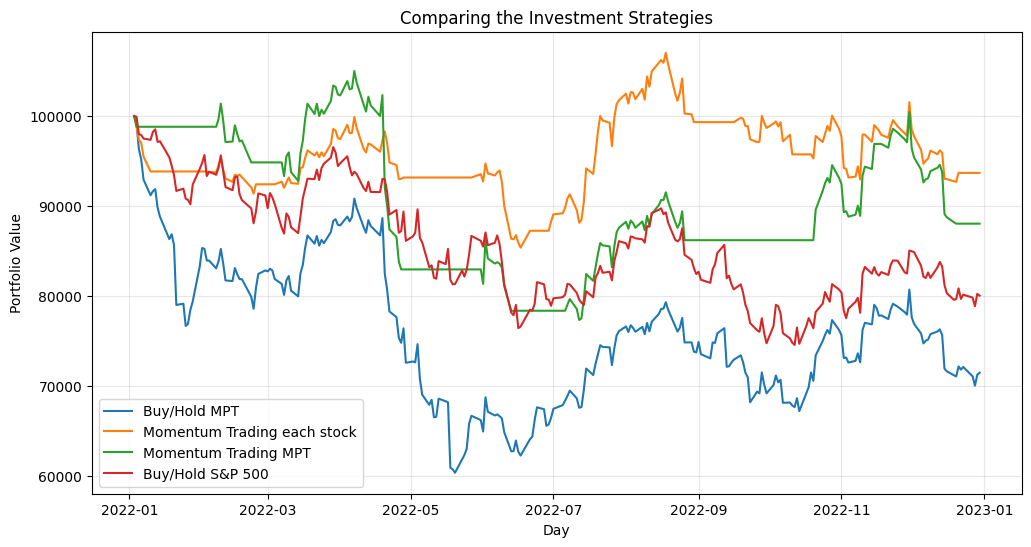

In [ ]:
# plot all the strategies
plt.plot(buy_hold1['value'], label='Buy/Hold MPT') # buy and hold NFLX, UNH, and COST
plt.plot(table1['total_value'], label='Momentum Trading each stock') # momentum trading each stocks individually
plt.plot(port['total_value'], label='Momentum Trading MPT') # momentum trading all stocks at once
plt.plot(buy_hold2['value'], label='Buy/Hold S&P 500') # buy and hold ^GSPC

plt.legend(loc='lower left') # legend
plt.title('Comparing the Investment Strategies') # title
plt.xlabel('Day') # x axis
plt.ylabel('Portfolio Value') # y axis
plt.grid(True, alpha=.3) # grid
plt.show()

## 3.6 Discussion and Comparison of the Investment Strategies

In our MPT optimized allocation, ultimately we decided to select the portfolio at the risk level of 0.000196 where 35.19% is in NFLX, 7.63% is in UNH, and 57.18% is in COST. When deploying our Buy and Hold strategy, we keep our portfolio relatively stable over a longer period, regardless of short-term fluctuations. For our momentum trading strategy, the idea is to buy stocks that are rising and sell them when they appear to have peaked. Leveraging this principle, we bought if the 8-day average was greater than the 21-day average.

For results, both buy & hold strategies yielded negative returns for the 1 year period. For momentum trading with our 3 individually selected stocks, Netflix and Costco yielded negative returns while United Healthcare yielded positive returns over the 1 year period.

As shown by the S&P 500, it was a bad year for the stock market, in general. Two of our explored strategies (Momentum Trading MPT and Momentum Trading each stock) outperformed the S&P 500 by thousands of dollars. The poor results from the Buy/Hold MPT portfolio reflect the limited diversity, relative to the S&P 500. In many situations, outperforming the S&P 500 is considered a success, regardless of if the returns are positive or negative, but this is for the investor to decide, preferrably prior to implementing the strategy.

# 4 - Conclusion

## 4.1 Thoughts and Insights

This exercise provided valuable insights around the pros and cons of MPT and momentum trading. Some key takeaways that we'd like to highlight are:



*   Momentum Trading is a high risk, high reward strategy that may not be the most ideal for conservative investors
*   Buy & Hold is a more conservative way to invest, and one shouldn't be discouraged by negative returns in a single year
* Daily cumulative returns as a percentage is a good method for visualizing stocks performance against each other over a period
* All of our stock picks had a steep dropoff in early 2020, which is an indicator of the broader market decrease at the on-set of the pandemic.
* Our stock picks for the Healthcare and Consumer staples sectors recovered better from the pandemic than our picks for the communications sector
*  In selecting an appropriate allocation for an optimal portfolio under MPT, one must consider diversification and an appropriate risk level


## 4.2 Individual Contributions
1. Thao:
  - Main coder
  - Second provider of insights for time series

2. Brian:
  - Main provider of insights
  - Second coder of Momentum Trading strategies and Time Series Visualizations

3. Chris:
  - Presenter
  - Second coder of Optimization Model
  - Second provider of insights for selecting portfolio and comparing strategies
  - Editing/proofreading

4. Rohith:
  - Second coder of Buy-and-Hold strategies
  - Organizing notebook using markdowns
